This tool is UNDER DEVELOPMENT. <br>The goal is, form a set of values based on unambiguous DNA/RNA ("A", "C", "G" and "T/U"), to find the most representative IUPACD ambiguous letters. <br> Ambiguous letters are digitized as four-dimention vectors. For example, "A" as (1, 0, 0, 0), "C": (0, 1, 0, 0), "B"(not "A") as (0, 1/3, 1/3, 1/3), and "N" as (1/4, 1/4, 1/4, 1/4). <br>Given a set of measure {"A":120, "C":130, "G":3, "T":5}, AmbigN returns the letter "M" ("A" or "C"). <br>Likely, given a set of measure {"A":120, "C":130, "G":140, "T":5}, AmbigN returns the letter "V" (not "T").

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.  
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# useful imports
import logomaker as lm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()

# define legal ambiguous letters
try: 
    from Bio.Data.IUPACData import ambiguous_dna_values
    dna_vals = ambiguous_dna_values
    del dna_vals["X"]  # don't use letter "X"    
except ModuleNotFoundError: 
    print("No module named 'Bio'. Using saved values of ambiguous_dna_values.")
    dna_vals = {'A': 'A', 'C': 'C', 'G': 'G', 'T': 'T',
                'M': 'AC', 'R': 'AG', 'W': 'AT', 'S': 'CG', 'Y': 'CT', 'K': 'GT',
                'V': 'ACG', 'H': 'ACT', 'D': 'AGT', 'B': 'CGT',
                'N': 'ACGT'
               }
except:
    print("Something else than Biopython went wrong.")

dna_letters = "".join(list(dna_vals.keys()))
dna_keys = dict([(v, k) for k, v in dna_vals.items()])  # swap key-value pairs
dna_keys["ACGT"] = "N"

# My ambiguous DNA letter classifier, using A, C, G, T four axes

In [3]:
# my ambiguous DNA letter classifier, "ACGT"
def digitizeNt(s):
    if not s in dna_letters: raise ValueError('The arg is not a DNA letter.')
    coordinate = [0,0,0,0]
    S = dna_vals[s]
    quant = 1.0 / len(S)
    if "A" in S: coordinate[0] = quant
    if "C" in S: coordinate[1] = quant
    if "G" in S: coordinate[2] = quant
    if "T" in S: coordinate[3] = quant
    return np.array(coordinate)

def digitizeNseq(Seq):
    coordinates = [digitizeNt(s) for s in Seq]
    return np.array(coordinates)

#Nt_dig_dic = dict([(i, digitizeNt(i)) for i in dna_letters])
#nt_dig_dic = dict([(N.lower(), invert4(digitizeNt(N))) for N in Nt_dig_dic])
Nt_dig_array = digitizeNseq(dna_letters)

def normalize4(Fr):
    "Unity-based normalization of four non-negative numbers."
    Fr = np.array(Fr)
    Sum = sum(abs(Fr))
    return np.array((0,0,0,0)) if Sum == 0 else Fr/Sum
        
def cloest_ambigous_letter(Fr, Top_N = 4, show_distance_difference = False):
    "Fined the top N representive ambiguous letter from ACGT frequency at a position."
    coordinate = normalize4(Fr)
    compare_array = coordinate - Nt_dig_array
    norm = np.sum(compare_array**2, axis = 1)**0.5
    topNnorm = sorted(norm)[0:Top_N]

    pos = np.empty(0)
    for val in sorted(set(topNnorm)):
        pos = np.append(pos, np.where(norm == val)[0])
    
    Amb = [dna_letters[i] for i in pos.astype(int)]
    if not show_distance_difference:
        return pos
    else:
        norm = np.array([sum(np.square(coordinate - Nt_dig_array[dna_letters.find(i)])) for i in Amb])
        norm_diff = norm - norm[0]
        return Amb, norm_diff

In [3]:
# Show coordinates of all ambiguous DNA letters
dict([(dna_letters[i], Nt_dig_array[i]) for i in range(len(dna_letters))])

{'G': array([0., 0., 1., 0.]),
 'A': array([1., 0., 0., 0.]),
 'T': array([0., 0., 0., 1.]),
 'C': array([0., 1., 0., 0.]),
 'R': array([0.5, 0. , 0.5, 0. ]),
 'Y': array([0. , 0.5, 0. , 0.5]),
 'W': array([0.5, 0. , 0. , 0.5]),
 'S': array([0. , 0.5, 0.5, 0. ]),
 'M': array([0.5, 0.5, 0. , 0. ]),
 'K': array([0. , 0. , 0.5, 0.5]),
 'H': array([0.33333333, 0.33333333, 0.        , 0.33333333]),
 'B': array([0.        , 0.33333333, 0.33333333, 0.33333333]),
 'V': array([0.33333333, 0.33333333, 0.33333333, 0.        ]),
 'D': array([0.33333333, 0.        , 0.33333333, 0.33333333]),
 'N': array([0.25, 0.25, 0.25, 0.25])}

# Expand ambiguous letters to handle negative input / effect

In [4]:
# Upper case letters means positive value/effect.
# These variables and functions don't need to revise
"""
dna_letters, 
Nt_dig_array,
digitizeNt(s)
"""

# Lower case letters means positive value/effect.
X_letters = dna_letters + dna_letters.lower()
nt_dig_array = Nt_dig_array * -1  # Nt_dig_array = digitizeNseq(dna_letters)
Xt_dig_array = np.concatenate((Nt_dig_array, nt_dig_array))

def digitizeXt(s):
    if not s in X_letters: raise ValueError('The arg is not a DNA+ letter.')
    coordinate = Xt_dig_array[X_letters.find(s)]
    return coordinate

def digitizeXseq(Seq):
    coordinates = [digitizeXt(s) for s in Seq]
    return np.array(coordinates)

# normalize negative input
def normalabs4(Fr):
    "Unity-based normalization of any four numbers."
    Fr = np.array(Fr)
    Sum = sum(abs(Fr))
    return np.array((0,0,0,0)) if Sum == 0 else Fr/Sum

def cloest_ambigous_abs(Fr, Top_N = 4, show_distance_difference = False):
    "Fined the top N representive ambiguous letter from ACGT frequency at a position."
    coordinate = normalabs4(Fr)  # normalabs4()
    compare_array = coordinate - Xt_dig_array
    norm = np.sum(compare_array**2, axis = 1)**0.5
    topNnorm = sorted(norm)[0:Top_N]

    pos = np.empty(0)
    for val in sorted(set(topNnorm)):
        pos = np.append(pos, np.where(norm == val)[0])
    
    Amb = [X_letters[i] for i in pos.astype(int)]
    if not show_distance_difference:
        return pos
    else:
        norm = np.array([sum(np.square(coordinate - Xt_dig_array[X_letters.find(i)])) for i in Amb])
        norm_diff = norm - norm[0]
        return Amb, norm_diff

In [5]:
# Show coordinates of expanded ambiguous DNA letters
Xt_dig_dic = dict([(X_letters[i], Xt_dig_array[i]) for i in range(len(X_letters))])
Xt_dig_dic

{'A': array([1., 0., 0., 0.]),
 'C': array([0., 1., 0., 0.]),
 'G': array([0., 0., 1., 0.]),
 'T': array([0., 0., 0., 1.]),
 'M': array([0.5, 0.5, 0. , 0. ]),
 'R': array([0.5, 0. , 0.5, 0. ]),
 'W': array([0.5, 0. , 0. , 0.5]),
 'S': array([0. , 0.5, 0.5, 0. ]),
 'Y': array([0. , 0.5, 0. , 0.5]),
 'K': array([0. , 0. , 0.5, 0.5]),
 'V': array([0.33333333, 0.33333333, 0.33333333, 0.        ]),
 'H': array([0.33333333, 0.33333333, 0.        , 0.33333333]),
 'D': array([0.33333333, 0.        , 0.33333333, 0.33333333]),
 'B': array([0.        , 0.33333333, 0.33333333, 0.33333333]),
 'N': array([0.25, 0.25, 0.25, 0.25]),
 'a': array([-1., -0., -0., -0.]),
 'c': array([-0., -1., -0., -0.]),
 'g': array([-0., -0., -1., -0.]),
 't': array([-0., -0., -0., -1.]),
 'm': array([-0.5, -0.5, -0. , -0. ]),
 'r': array([-0.5, -0. , -0.5, -0. ]),
 'w': array([-0.5, -0. , -0. , -0.5]),
 's': array([-0. , -0.5, -0.5, -0. ]),
 'y': array([-0. , -0.5, -0. , -0.5]),
 'k': array([-0. , -0. , -0.5, -0.5]),
 

# Dealing with sequence.  Reduced "if statements" for faster speed

In [27]:
# Fined the closest ambiguous letter from ACGT frequency at a position
# for non-negative input only
# Without oupputing distance


def coordinates_checker(matrix):
    # Check data type
    if not isinstance(matrix, np.ndarray):
        if not isinstance(matrix, pd.core.frame.DataFrame):
            raise TypeError("Input is neither an Numpy ndarray nor a Pandas DataFrame.")  
    # Check data shape
    if matrix.shape[1] != 4:
        raise ValueError("Column number of the input matrix isn't 4.")
    pass


def first_ambigous_letter(coordinate):
    "coordinate must be normalized."
    compare_array = coordinate - Nt_dig_array
    dist2 = np.sum(np.square(compare_array), axis = 1)  # square of norm
    Amb = dna_letters[dist2.argmin()]
    return Amb

def first_ambigous_seq(Frs, input_normalized = False):
    """
    Take an N by 4 matrix.  4 digits along the 2nd axis correspond to 'A'. 'C', 'G' and 'T/U'.
    """
    coordinates_checker(Frs)  # check input matrix
    
    if input_normalized:
        coordinates = Frs
    else:
        coordinates = np.apply_along_axis(normalize4, 1, Frs)  # normalize input matrix
    Ambs = np.apply_along_axis(first_ambigous_letter, 1, coordinates)
    seq = "".join(Ambs)
    return seq

# Output distance values
def first_ambdist_letter(coordinate):
    "coordinate must be normalized."
    compare_array = coordinate - Nt_dig_array
    dist2 = np.sum(np.square(compare_array), axis = 1)  # square of norm
    index = dist2.argmin()
    Amb = dna_letters[index]
    return Amb, dist2[index]

def first_ambdist_seq(Frs, input_normalized = False):
    """
    Take an N by 4 matrix.  4 digits along the 2nd axis correspond to 'A'. 'C', 'G' and 'T/U'.
    Return the proximal ambiguous sequence as a string and the distances as an Numpy array.
    """
    coordinates_checker(Frs)  # check input matrix
    
    if input_normalized:
        coordinates = Frs
    else:
        coordinates = np.apply_along_axis(normalize4, 1, Frs)  # normalize input matrix
    tmp_arr = np.apply_along_axis(first_ambdist_letter, 1, coordinates)
    Ambs = tmp_arr[:,0].astype('U1')  # store as unicode string
    seq = "".join(Ambs) 
    dist2s = tmp_arr[:,1].astype(float)
    norms = np.sqrt(dist2s)  # turn square back to norm
    return seq, norms

# for both negative and positive input
# Without oupputing distance
def posneg_ambigous_letter(coordinate):
    "coordinate must be normalized."
    compare_array = coordinate - Xt_dig_array
    dist2 = np.sum(np.square(compare_array), axis = 1)  # square of norm
    Amb = X_letters[dist2.argmin()]
    return Amb

def posneg_ambigous_seq(Frs, input_normalized = False):
    """
    Take an N by 4 matrix.  4 digits along the 2nd axis correspond to 'A'. 'C', 'G' and 'T/U'.
    """
    coordinates_checker(Frs)  # check input matrix

    if input_normalized:
        coordinates = Frs
    else:
        coordinates = np.apply_along_axis(normalabs4, 1, Frs)  # normalize input matrix
    Ambs = np.apply_along_axis(posneg_ambigous_letter, 1, coordinates)
    seq = "".join(Ambs)
    return seq

# Output distance values
def posneg_ambdist_letter(coordinate):
    "coordinate must be normalized."
    compare_array = coordinate - Xt_dig_array
    dist2 = np.sum(np.square(compare_array), axis = 1)  # square of norm
    index = dist2.argmin()
    Amb = X_letters[index]
    return Amb, dist2[index]

def posneg_ambdist_seq(Frs, input_normalized = False):
    """
    Take an N by 4 matrix.  4 digits along the 2nd axis correspond to 'A'. 'C', 'G' and 'T/U'.
    Return the proximal ambiguous sequence as a string and the distances as an Numpy array.
    """
    coordinates_checker(Frs)  # check input matrix

    if input_normalized:
        coordinates = Frs
    else:
        coordinates = np.apply_along_axis(normalabs4, 1, Frs)  # normalize input matrix
    tmp_arr = np.apply_along_axis(posneg_ambdist_letter, 1, coordinates)
    Ambs = tmp_arr[:,0].astype('U1')  # store as unicode string
    seq = "".join(Ambs) 
    dist2s = tmp_arr[:,1].astype(float)
    norms = np.sqrt(dist2s)  # turn square back to norm
    return seq, norms

In [25]:
first_ambdist_seq(Nt_dig_array)

('ACGTMRWSYKVHDBN',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [32]:
posneg_ambdist_seq(nt_dig_array, input_normalized = True)

('acgtmrwsykvhdbn',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# Visualization with Logomaker
[Logomaker](https://logomaker.readthedocs.io/en/latest/?badge=latest)  
[Tutorial](https://github.com/jbkinney/logomaker/tree/master/logomaker/tutorials)

In [8]:
def array_to_Logomaker_input(arr):
    "Pack an N by 4 numpy array into a dataframe that can be processed by Logomaker."
    return pd.DataFrame(arr, columns = list("ACGT"))

Text(0, 0.5, 'Normalization')

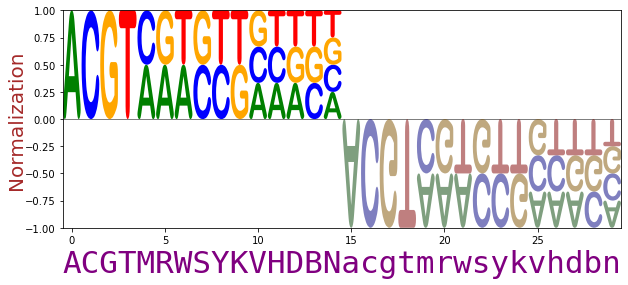

In [12]:
# create and style logo
Xt_dig_df = array_to_Logomaker_input(Xt_dig_array)

logo1 = lm.Logo(Xt_dig_df, 
                font_name = 'Arial Rounded MT Bold',
                fade_below=0.5,
                shade_below=0.5,
                figsize=(10,4)
               )
# set axes labels
logo1.ax.set_xlabel(X_letters,{'fontname':'monospace'}, fontsize=31, color='purple')
logo1.ax.set_ylabel("Normalization", labelpad=-1, fontsize=20, color = 'brown')

## Random test

In [9]:
low, high, size = 0,(2,4,2,3), (20,4)
# positive values only
test_positive_random = np.random.randint(low, high, size=size) + 0.01  # ZEROs cause error in Logomaker
positive_amb_seq = first_ambigous_seq(test_positive_random)

positive_df = array_to_Logomaker_input(test_positive_random)
positive_df_normalized = lm.transform_matrix(positive_df, normalize_values=True)

print(positive_amb_seq)

# positive and negative values
# m.transform_matrix(matrix, normalize_values=True) doen't allow negative values
test_posneg_random = test_positive_random * (np.random.randint(2, size=size) - 0.5)
posneg_array_normalized = np.apply_along_axis(normalabs4, 1, test_posneg_random)  # normalabs4()
posneg_amb_seq = posneg_ambigous_seq(posneg_array_normalized, input_normalized = True)

posneg_df = array_to_Logomaker_input(test_posneg_random)
posneg_df_normalized = array_to_Logomaker_input(posneg_array_normalized)

print(posneg_amb_seq)

MHNBYHABNTMYYWHHGKBN
cWKMYHABBTRccwYygKcn


Text(0, 0.5, 'Normalized')

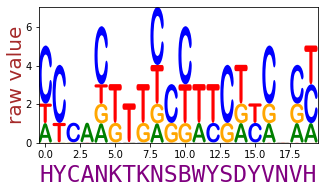

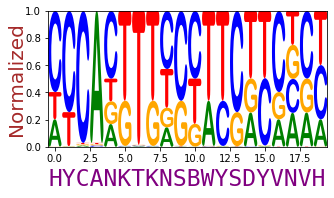

In [33]:
logo2 = lm.Logo(positive_df, 
                font_name = 'Arial Rounded MT Bold',
                fade_below=0.5,
                shade_below=0.5,
                figsize=(5,2.5)
               )
# set axes labels
logo2.ax.set_xlabel(positive_amb_seq,{'fontname':'monospace'}, fontsize=23, color='purple')
logo2.ax.set_ylabel("raw value", labelpad=-1, fontsize=20, color = 'brown')

logo3 = lm.Logo(positive_df_normalized,
                font_name = 'Arial Rounded MT Bold',
                fade_below=0.5,
                shade_below=0.5,
                figsize=(5,2.5)
               )
# set axes labels
logo3.ax.set_xlabel(positive_amb_seq,{'fontname':'monospace'}, fontsize=23, color='purple')
logo3.ax.set_ylabel("Normalized", labelpad=-1, fontsize=20, color = 'brown')


Text(0, 0.5, 'Normalized')

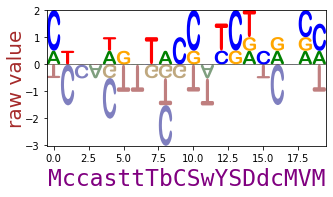

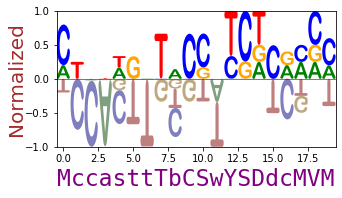

In [34]:
logo4 = lm.Logo(posneg_df, 
                font_name = 'Arial Rounded MT Bold',
                fade_below=0.5,
                shade_below=0.5,
                figsize=(5,2.5)
               )
# set axes labels
logo4.ax.set_xlabel(posneg_amb_seq,{'fontname':'monospace'}, fontsize=23, color='purple')
logo4.ax.set_ylabel("raw value", labelpad=-1, fontsize=20, color = 'brown')

logo5 = lm.Logo(posneg_df_normalized,
                font_name = 'Arial Rounded MT Bold',
                fade_below=0.5,
                shade_below=0.5,
                figsize=(5,2.5)
               )
# set axes labels
logo5.ax.set_xlabel(posneg_amb_seq,{'fontname':'monospace'}, fontsize=23, color='purple')
logo5.ax.set_ylabel("Normalized", labelpad=-1, fontsize=20, color = 'brown')

In [21]:
posneg_df

,A,C,G,T
0,0.505,0.005,0.005,-0.005
1,0.005,-0.505,-0.005,0.005
2,0.505,-1.005,-0.505,0.005
3,0.005,1.505,-0.005,-0.005
4,0.505,-1.505,0.505,0.005
5,0.505,-1.505,-0.005,1.005
6,-0.505,-0.505,-0.005,0.505
7,0.005,1.005,0.005,-0.005
8,-0.005,1.005,0.505,-0.505
9,0.005,0.005,0.005,-1.005


# Check input datatype / format

In [12]:
matrix, array check. 
isinstance(positive_df, pd.core.frame.DataFrame)

True

In [15]:
type(test_positive_random)
isinstance(test_positive_random, np.ndarray)

True

# More ambiguous sequence candidates

In [13]:
# Output distance values
def posneg_ambdist_top2(coordinate):
    "return two proximal letters with difference in dist2."
    "coordinate must be normalized."
    compare_array = coordinate - Xt_dig_array
    dist2 = np.sum(np.square(compare_array), axis = 1)  # square of norm
    top2 = sorted(dist2)[0:2]  # two smallest
    
    pos = np.where(dist2 == top2[0])[0]
    pos = np.append(pos, np.where(dist2 == top2[1])[0])
    Amb1, Amb2 = X_letters[pos[0]], X_letters[pos[1]]
    diff = top2[1] - top2[0]
    return Amb1, Amb2, diff

def posneg_ambdist_seq_top2(Frs, input_normalized = False):
    """
    Take an N by 4 matrix.  4 digits along the 2nd axis correspond to 'A'. 'C', 'G' and 'T/U'.
    Return the proximal ambiguous sequence as a string and the distances as an Numpy array.
    """
    # check input data type
    if type(Fr)
    
    if input_normalized:
        coordinates = Frs
    else:
        coordinates = np.apply_along_axis(normalabs4, 1, Frs)  # normalize input matrix
    tmp_arr = np.apply_along_axis(posneg_ambdist_top2, 1, coordinates)
    Ambs = tmp_arr[:,0].astype('U1')  # store as unicode string
    seq = "".join(Ambs)
    Ambs2 = tmp_arr[:,1].astype('U1')  # store as unicode string
    seq2 = "".join(Ambs2) 
    dist2s = tmp_arr[:,2].astype(float)
    dist = np.sqrt(dist2s)  # turn square back to 'distance'

    steps = len(seq) # expand_top2
    seq_score = {seq: (0,0)}
    for i in range(steps):
        tmp = seq[0:i] + seq2[i] + seq[i+1:]
        seq_score[tmp] = (dist[i],i+1)
        seq_sorted = sorted(seq_score.items(), key=lambda item: item[1][0])
    return seq_sorted

## Random test

In [16]:
posneg_ambdist_seq_top2(test_positive_random)

[('YYYYYCYYYBYTNYYYYHCY', (0, 0)),
 ('YYYYYCYYYBYKNYYYYHCY', (0.0, 12)),
 ('YYYYYCYHYBYTNYYYYHCY', (0.1360827634879544, 8)),
 ('YYYYYCYYYBYTNYYYYWCY', (0.1825741858350554, 18)),
 ('YYHYYCYYYBYTNYYYYHCY', (0.2041241452319315, 3)),
 ('YYYYYCYYYBYTNYYYHHCY', (0.21320071635561041, 17)),
 ('YYYYYCYYYBYTNYYYYHYY', (0.2132007163556105, 19)),
 ('YYYYYCYYYBYTHYYYYHCY', (0.22360679774997894, 13)),
 ('YYYBYCYYYBYTNYYYYHCY', (0.23570226039551584, 4)),
 ('YYYYYCYYYBYTNYYHYHCY', (0.25819888974716115, 16)),
 ('YYYYYCYYYBHTNYYYYHCY', (0.26726124191242434, 11)),
 ('YYYYYCYYYBYTNYBYYHCY', (0.2752409412815901, 15)),
 ('YYYYYCYYBBYTNYYYYHCY', (0.27524094128159016, 9)),
 ('YYYYYCYYYBYTNHYYYHCY', (0.27524094128159016, 14)),
 ('YYYYHCYYYBYTNYYYYHCY', (0.2886751345948129, 5)),
 ('YYYYYCYYYNYTNYYYYHCY', (0.2886751345948129, 10)),
 ('YYYYYCYYYBYTNYYYYHCB', (0.29957234475763905, 20)),
 ('YBYYYCYYYBYTNYYYYHCY', (0.31622776601683794, 2)),
 ('HYYYYCYYYBYTNYYYYHCY', (0.408248290463863, 1)),
 ('YYYYYCHYYBYTNYYYYHCY',

In [22]:
posneg_ambdist_seq(test_positive_random)

('ACVCVHHCBTHDSNVYBVYN',
 array([0.03330867, 0.03330867, 0.20212332, 0.01139507, 0.32401468,
        0.23414912, 0.00379836, 0.01698089, 0.20212332, 0.01698089,
        0.16201949, 0.20212332, 0.00980392, 0.        , 0.00379836,
        0.00980392, 0.00379836, 0.20212332, 0.35008787, 0.28676338]))

In [23]:
posneg_ambdist_seq(test_posneg_random)

('AcsCcWmCStmdRVrdSscV',
 array([0.03330867, 0.03330867, 0.35357072, 0.01139507, 0.49249533,
        0.62213776, 0.40826596, 0.01698089, 0.35357072, 0.01698089,
        0.50897401, 0.20212332, 0.70020868, 0.28867513, 0.40826596,
        0.69787121, 0.40826596, 0.35357072, 0.35708824, 0.33223325]))

# Ambiguous letter  inner and outer

In [24]:
# Intersection (inner) and union (outer) of two ambighous DNA sequences
# Only accept dna_letters

def DNAnt_letter_checker(a,b):
    a = a.upper(); b = b.upper()
    if not a in dna_letters: 
        raise ValueError('The first arg is not a DNA letter.')
    elif not b in dna_letters: 
        raise ValueError('The second arg is not a DNA letter.')
    else:
        return True

def DNAseq_letter_checker(dna1, dna2):
    "Return False if any input sequences contains illegal DNA letter. Only accept letters in Bio.Data.IUPACData.ambiguous_dna_letter ."
    dna1 = dna1.upper(); dna2 = dna2.upper()
    if not all(i in dna_letters for i in dna1): 
        raise ValueError('The dna1 contains illegal DNA letter.')
    elif not all(i in dna_letters for i in dna2): 
        raise ValueError('The dna2 contains illegal DNA letter.')
    else:
        return True

def dna_inner(a,b):
    "Only accept letters in Bio.Data.IUPACData.ambiguous_dna_letter ."
    inner = set(dna_vals[a]).intersection(set(dna_vals[b]))
    if len(inner) == 0:
        return "X"
    else:
        return dna_keys["".join(sorted(list(inner)))]

def dna_outer(a,b):
    "Only accept letters in Bio.Data.IUPACData.ambiguous_dna_letter ."
    outer = set(dna_vals[a]).union(set(dna_vals[b]))
    return dna_keys["".join(sorted(list(outer)))]

amb_dna_inner_dic, amb_dna_outer_dic = {}, {}  # create Cayley tables
for i in dna_letters:
    for j in dna_letters:
        amb_dna_inner_dic[i+j] = dna_inner(i,j)
        amb_dna_outer_dic[i+j] = dna_outer(i,j)
        
def amb_seq_inner(dna1, dna2):
    "Args dna1 and dna2 must be of equal length."
    inner = ""
    for a, b in zip(list(dna1), list(dna2)):
        inner = inner + amb_dna_inner_dic[a+b]
    return inner

def amb_seq_outer(dna1, dna2):
    "Args dna1 and dna2 must be of equal length."
    outer = ""
    for a, b in zip(list(dna1), list(dna2)):
        outer = outer + amb_dna_outer_dic[a+b]
    return outer

In [25]:
DNAseq_letter_checker("ABC", "ABH")

True

In [26]:
print(dna_inner("K","H"), dna_outer("K","H"))

T N


In [27]:
 print(amb_seq_inner("NNGRRT", "CCNSRT"),amb_seq_outer("NNGRRT", "CCSRRT"))

CCGGRT NNSRRT


In [28]:
 print(amb_seq_inner("WRKACGT", "SYMBDHV"),amb_seq_outer("WRKACGT", "SYMBDHV"))

XXXXXXX NNNNNNN
